# Library Import

In [14]:
#to display all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [15]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

#import scipy
import struct

from pathlib import Path
from sympy import divisors

from astropy.stats import jackknife_resampling
from astropy.stats import jackknife_stats

from scipy.stats import bootstrap

from scipy.optimize import curve_fit #for the fit

# Input Reading

## reading

In [16]:
#dirName = '../mesons-master/build/dat/'
#name = 'odd_prova26.odd_df2_4fop'
dirName = '../../data_from_scp/'
#name = 'tm_mesons_run3.mesons'
name = 'tm_mesons_run4.mesons'
datName = name + '.dat'

fileName = dirName + datName

In [17]:
plot_base_dir = 'plots/'
plot_dir = 'plot_'+name.split('.')[0]
Path(plot_base_dir+plot_dir).mkdir(parents=True, exist_ok=True)

In [18]:
verbose=True #True to print more output

step = 1 #steps at which configurations are read

early_stop = 0 #number of configurations (counting from the end) not read

In [19]:
#the correlators array will be stored in a dict having as keys the configurations
conf_dict = {}

#list with configurations number
conf_num_list = []

##### reading data from binary dat file #####
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

    #header is made up of 4 integers, 4x4=16byte
    header_size= 4*4

    #first 16 byte are four 4-byte integers
    ncorr, nnoise, tvals, noise_type = struct.unpack("iiii", fileContent[:header_size])

    #initialization of correlators' variables
    k1=['']*ncorr
    k2=['']*ncorr
    
    mu1=['']*ncorr
    mu2=['']*ncorr

    type1=['']*ncorr
    type2=['']*ncorr
    
    x0=['']*ncorr
    isreal=['']*ncorr

    
    #each correlator has an header of size given by 4x8 + 4x4 = 48byte
    corr_header_size = 4*8 + 4*4
    
    #then there are ncorr block, 8x8 + 4x4 (8 double and 4 int) with the following structure 
    for i in range(ncorr):
         k1[i], k2[i], mu1[i], mu2[i], type1[i], type2[i], x0[i], isreal[i] = struct.unpack("ddddiiii",fileContent[header_size+corr_header_size*i:header_size+corr_header_size*(i+1)])



    #initialization of correlators array
    corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex) #correlators
    

    #configuration start right after the header
    first_conf = header_size+corr_header_size*ncorr
    
    #we compute the lenght of the data block for each configuration
    #          sizeof(int) (=confNumber)           ncorr * nnoise * tvals * 2 (re+im) * 8 (sizeof(double))
    conf_len = 4                                 +  nnoise * tvals * (2*ncorr - np.sum(isreal))         * 8         
    #the term with isreal is there because for real correlators only the real part gets stored

    #starting right after the header we read each configuration block
    for start_conf in range(first_conf, len(fileContent)-conf_len*early_stop, conf_len*step):
    #for start_conf in range(first_conf, len(fileContent)-conf_len, conf_len):

        #breaks loop if the file does not contain the whole correlator for the given configuration
        if start_conf+conf_len > len(fileContent) :
            break

        #reading of the configuration number
        conf_number = struct.unpack("i",fileContent[start_conf:start_conf+4])[0]
        if verbose==True:
            print(f"Reading: Gauge Conf = {conf_number}\n")

        #store of conf num
        if conf_number not in conf_num_list:
            conf_num_list.append(conf_number)

        #initialize to 0 the array storing the correlators
        corr.fill(complex(0,0))

        #initialize start reading
        start_reading = start_conf + 4

        #loop over the correlators (ncorr blocks of...)
        for ic in range(ncorr):
            
            #reading of 2 point functions
            for t in range(tvals):
                
                for inoise in range(nnoise):

                    if isreal[ic]==0:
                        #read re and im
                        re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                        #store them
                        corr[ic][t][inoise] = complex(re,im)
                        #update start reading
                        start_reading = start_reading+16

                    if isreal[ic]==1:
                        #read re
                        re = struct.unpack("d",fileContent[start_reading:start_reading+8])[0]
                        #store it
                        corr[ic][t][inoise] = complex(re,0.0)
                        #update start reading
                        start_reading = start_reading+8
                        
                    

        #store of correlators associated to the given configuration
        conf_dict[str(conf_number)] = corr.copy()

Reading: Gauge Conf = 1

Reading: Gauge Conf = 2

Reading: Gauge Conf = 3

Reading: Gauge Conf = 4

Reading: Gauge Conf = 5

Reading: Gauge Conf = 6

Reading: Gauge Conf = 7

Reading: Gauge Conf = 8

Reading: Gauge Conf = 9

Reading: Gauge Conf = 10

Reading: Gauge Conf = 11

Reading: Gauge Conf = 12

Reading: Gauge Conf = 13

Reading: Gauge Conf = 14

Reading: Gauge Conf = 15

Reading: Gauge Conf = 16

Reading: Gauge Conf = 17

Reading: Gauge Conf = 18

Reading: Gauge Conf = 19

Reading: Gauge Conf = 20

Reading: Gauge Conf = 21

Reading: Gauge Conf = 22

Reading: Gauge Conf = 23

Reading: Gauge Conf = 24

Reading: Gauge Conf = 25

Reading: Gauge Conf = 26

Reading: Gauge Conf = 27

Reading: Gauge Conf = 28

Reading: Gauge Conf = 29

Reading: Gauge Conf = 30

Reading: Gauge Conf = 31

Reading: Gauge Conf = 32

Reading: Gauge Conf = 33

Reading: Gauge Conf = 34

Reading: Gauge Conf = 35

Reading: Gauge Conf = 36

Reading: Gauge Conf = 37

Reading: Gauge Conf = 38

Reading: Gauge Conf =

In [20]:
#check on correct lenght calculations
(len(fileContent)-header_size-corr_header_size*ncorr)/conf_len

914.0

In [21]:
#construction of array with names and numbers of configurations
conf_names = list(conf_dict.keys())
conf_list = [int(conf) for conf in conf_names ]
nconf = len(conf_list)
nconf

914

In [22]:
#creation of a numpy array with all the correlators
correlators = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
for iconf,nameconf in enumerate(conf_names):
    correlators[iconf] = conf_dict[nameconf]

In [23]:
if verbose:
    print("(nconf, ncorrelators, tvals, nnoise)")
    print(np.shape(correlators))

(nconf, ncorrelators, tvals, nnoise)
(914, 2, 32, 100)


In [25]:
if verbose:
    for icorr in range(ncorr):
        print(f"k1  = {k1[icorr]}\n")
        print(f"k2  = {k2[icorr]}\n")
        print(f"mu1 = {mu1[icorr]}\n")
        print(f"mu2 = {mu2[icorr]}\n")
        print(f"G1  = {type1[icorr]}\n")
        print(f"G2  = {type2[icorr]}\n")
        print(f"x0  = {x0[icorr]}\n")
        print(f"isr = {isreal[icorr]}\n\n")

k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = 0.0454

G1  = 5

G2  = 5

x0  = 1

isr = 1


k1  = 0.135217

k2  = 0.135217

mu1 = 0.0454

mu2 = -0.0454

G1  = 5

G2  = 5

x0  = 30

isr = 0




In [12]:
corr_x = correlators[:,0,:,:]
corr_z = correlators[:,1,:,:]

if verbose:
    print("(nconf, tvals, nnoise)")
    print(np.shape(corr_x))
    print(np.shape(corr_z))

(nconf, tvals, nnoise)
(914, 32, 100)
(914, 32, 100)


## Average over Noise

In [13]:
corr_x_navg = corr_x.mean(axis=-1)
corr_z_navg = corr_z.mean(axis=-1)

if verbose:
    print("(nconf, ncorrelators, tvals)")
    print(np.shape(corr_x_navg))
    print(np.shape(corr_z_navg))

(nconf, ncorrelators, tvals)
(914, 32)
(914, 32)


In [14]:
corr_x_navg[0]
corr_x_navg.mean(axis=0)

array([0.00000000e+00+0.j, 5.32085140e+03+0.j, 7.79014072e+02+0.j,
       2.57158129e+02+0.j, 1.06663012e+02+0.j, 4.81531855e+01+0.j,
       2.24735639e+01+0.j, 1.06455030e+01+0.j, 5.08069273e+00+0.j,
       2.43502455e+00+0.j, 1.16998829e+00+0.j, 5.63063191e-01+0.j,
       2.71264974e-01+0.j, 1.30780811e-01+0.j, 6.30830423e-02+0.j,
       3.04393758e-02+0.j, 1.46916202e-02+0.j, 7.09225045e-03+0.j,
       3.42418763e-03+0.j, 1.65339268e-03+0.j, 7.98424772e-04+0.j,
       3.85609929e-04+0.j, 1.86302742e-04+0.j, 9.01361757e-05+0.j,
       4.38659319e-05+0.j, 2.18766276e-05+0.j, 1.19959116e-05+0.j,
       8.75451754e-06+0.j, 1.03581951e-05+0.j, 1.76942738e-05+0.j,
       3.48225424e-05+0.j, 0.00000000e+00+0.j])

array([0.00000000e+00+0.j, 5.28529312e+03+0.j, 7.64888608e+02+0.j,
       2.50424922e+02+0.j, 1.03436675e+02+0.j, 4.66015067e+01+0.j,
       2.17257187e+01+0.j, 1.02846640e+01+0.j, 4.90648413e+00+0.j,
       2.35089426e+00+0.j, 1.12935380e+00+0.j, 5.43435792e-01+0.j,
       2.61784310e-01+0.j, 1.26201345e-01+0.j, 6.08710301e-02+0.j,
       2.93709221e-02+0.j, 1.41755375e-02+0.j, 6.84297527e-03+0.j,
       3.30378508e-03+0.j, 1.59523712e-03+0.j, 7.70334747e-04+0.j,
       3.72041058e-04+0.j, 1.79746228e-04+0.j, 8.69637097e-05+0.j,
       4.23218902e-05+0.j, 2.11065417e-05+0.j, 1.15736157e-05+0.j,
       8.44631194e-06+0.j, 9.99351717e-06+0.j, 1.70713081e-05+0.j,
       3.35965349e-05+0.j, 0.00000000e+00+0.j])

In [15]:
corr_z_navg[0]
corr_z_navg.mean(axis=0)
(corr_z_navg.mean(axis=0).imag/corr_z_navg.mean(axis=0).real)[1:-1]

array([ 0.00000000e+00+0.00000000e+00j,  3.25449593e-05+1.80974579e-07j,
        1.54175257e-05+8.57327446e-08j,  6.26885145e-06+3.48583236e-08j,
        3.60417081e-08+1.96854718e-10j, -6.73003532e-06-3.74339972e-08j,
       -1.77733536e-05-9.88605413e-08j, -3.92042002e-05-2.18079718e-07j,
       -8.28793528e-05-4.61076602e-07j, -1.72960121e-04-9.62350205e-07j,
       -3.59273492e-04-1.99937143e-06j, -7.44859357e-04-4.14620695e-06j,
       -1.54291755e-03-8.59140344e-06j, -3.19458274e-03-1.77962676e-05j,
       -6.61246054e-03-3.68584397e-05j, -1.36840101e-02-7.63370470e-05j,
       -2.83113848e-02-1.58107592e-04j, -5.85575355e-02-3.27499923e-04j,
       -1.21069787e-01-6.78473860e-04j, -2.50180182e-01-1.40587105e-03j,
       -5.16571375e-01-2.91396303e-03j, -1.06537931e+00-6.04223920e-03j,
       -2.19333730e+00-1.25359069e-02j, -4.50261036e+00-2.60287846e-02j,
       -9.19800606e+00-5.41037132e-02j, -1.86175127e+01-1.12631948e-01j,
       -3.69454345e+01-2.34967967e-01j, -6.96094407

array([ 0.00000000e+00+0.00000000e+00j,  3.30182049e-05+1.54692897e-09j,
        1.56417158e-05+7.32821386e-10j,  6.36000695e-06+2.97952899e-10j,
        3.65610594e-08+1.65964937e-12j, -6.82791176e-06-3.20040856e-10j,
       -1.80318368e-05-8.45211523e-10j, -3.97743777e-05-1.86457144e-09j,
       -8.40847939e-05-3.94247593e-09j, -1.75475922e-04-8.22949144e-09j,
       -3.64499820e-04-1.70998277e-08j, -7.55696160e-04-3.54671548e-08j,
       -1.56536899e-03-7.35090845e-08j, -3.24107877e-03-1.52313791e-07j,
       -6.70873269e-03-3.15589291e-07j, -1.38833231e-02-6.53958138e-07j,
       -2.87239910e-02-1.35539925e-06j, -5.94116284e-02-2.81007160e-06j,
       -1.22837620e-01-5.82840666e-06j, -2.53838963e-01-1.20955709e-05j,
       -5.24142798e-01-2.51204311e-05j, -1.08104472e+00-5.22225167e-05j,
       -2.22574047e+00-1.08707496e-04j, -4.56960363e+00-2.26684187e-04j,
       -9.33639186e+00-4.73802516e-04j, -1.89028472e+01-9.93412360e-04j,
       -3.75313568e+01-2.09156067e-03j, -7.08012191

/tmp/ipykernel_64357/1785415807.py:3: RuntimeWarning: invalid value encountered in divide
  (corr_z_navg.mean(axis=0).imag/corr_z_navg.mean(axis=0).real)[1:-1]


array([ 4.68507896e-05,  4.68504475e-05,  4.68478890e-05,  4.53939080e-05,
        4.68724359e-05,  4.68732905e-05,  4.68787080e-05,  4.68869072e-05,
        4.68981234e-05,  4.69131307e-05,  4.69330885e-05,  4.69595891e-05,
        4.69947821e-05,  4.70415659e-05,  4.71038621e-05,  4.71870099e-05,
        4.72983433e-05,  4.74480593e-05,  4.76505684e-05,  4.79266933e-05,
        4.83074526e-05,  4.88410475e-05,  4.96069693e-05,  5.07479253e-05,
        5.25535837e-05,  5.57283521e-05,  6.25395768e-05,  8.54385292e-05,
       -1.19536692e-03,  7.54525706e-06])

## Preliminary plots and analysis

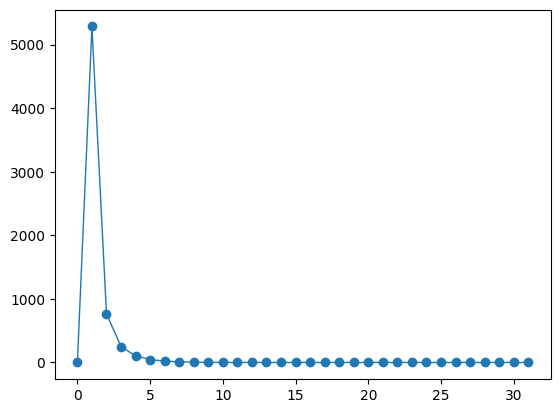

In [16]:
times = np.arange(tvals)

plt.plot(times,np.mean(corr_x_navg,axis=0).real, '-o',linewidth = 1)

Text(0.5, 1.0, 'cut = 3')

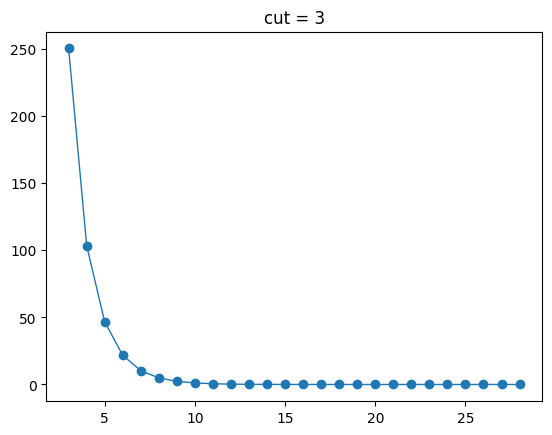

In [17]:
cut = 3
plt.title(f"cut = {cut}")
#plt.yscale('log')
plt.plot(times[cut:-cut],np.mean(corr_x_navg,axis=0).real[cut:-cut], '-o',linewidth = 1)

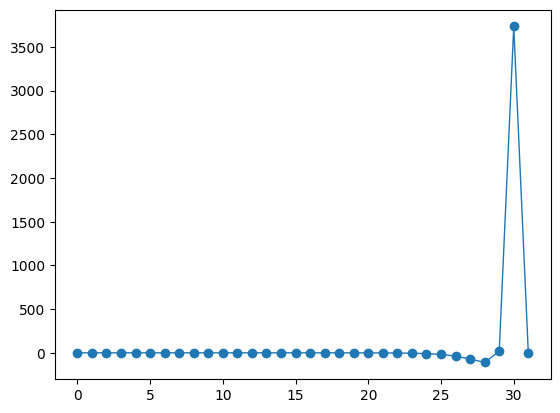

In [18]:
times = np.arange(tvals)

plt.plot(times,np.mean(corr_z_navg,axis=0).real, '-o',linewidth = 1)                     

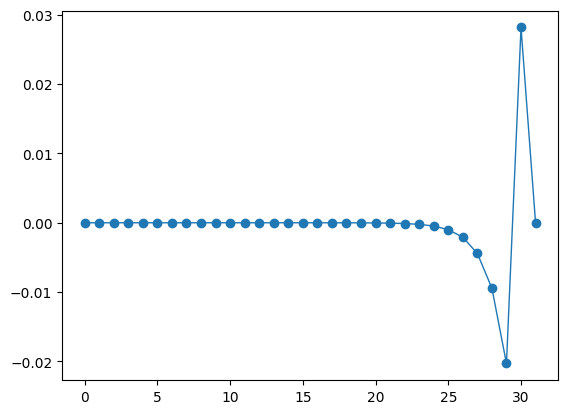

In [19]:
times = np.arange(tvals)

plt.plot(times,np.mean(corr_z_navg,axis=0).imag, '-o',linewidth = 1) 

Text(0.5, 1.0, 'cut = 3')

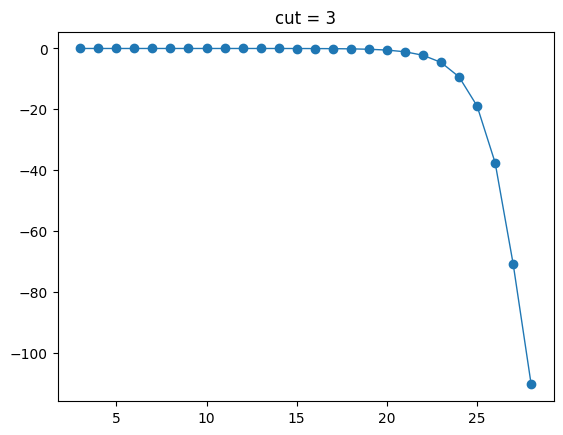

In [20]:
cut = 3
plt.title(f"cut = {cut}")
#plt.yscale('log')
plt.plot(times[cut:-cut],np.mean(corr_z_navg,axis=0).real[cut:-cut], '-o',linewidth = 1)

# Mass fit

In [34]:
eff_mass_x = np.empty(shape=(nconf,tvals-1))
eff_mass_z = np.empty(shape=(nconf,tvals-1))

for iconf in range(nconf):
    eff_mass_x[iconf,:] = np.array([np.log(corr_x_navg[iconf,i].real/corr_x_navg[iconf,i+1].real) for i in range(tvals-1)])
    eff_mass_z[iconf,:] = np.array([np.log(corr_z_navg[iconf,i].real/corr_z_navg[iconf,i-1].real) for i in range(1,tvals)])

if verbose:
    print("(nconf,tvals-1)")
    print(np.shape(eff_mass_x))
    print(np.shape(eff_mass_z))

(nconf,tvals-1)
(914, 31)
(914, 31)


/tmp/ipykernel_64357/1182758229.py:5: RuntimeWarning: divide by zero encountered in log
  eff_mass_x[iconf,:] = np.array([np.log(corr_x_navg[iconf,i].real/corr_x_navg[iconf,i+1].real) for i in range(tvals-1)])
/tmp/ipykernel_64357/1182758229.py:5: RuntimeWarning: divide by zero encountered in scalar divide
  eff_mass_x[iconf,:] = np.array([np.log(corr_x_navg[iconf,i].real/corr_x_navg[iconf,i+1].real) for i in range(tvals-1)])
/tmp/ipykernel_64357/1182758229.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  eff_mass_z[iconf,:] = np.array([np.log(corr_z_navg[iconf,i].real/corr_z_navg[iconf,i-1].real) for i in range(1,tvals)])
/tmp/ipykernel_64357/1182758229.py:6: RuntimeWarning: invalid value encountered in log
  eff_mass_z[iconf,:] = np.array([np.log(corr_z_navg[iconf,i].real/corr_z_navg[iconf,i-1].real) for i in range(1,tvals)])
/tmp/ipykernel_64357/1182758229.py:6: RuntimeWarning: divide by zero encountered in log
  eff_mass_z[iconf,:] = np.array([np.log(corr_z_navg[

## Some plots

<Figure size 640x480 with 0 Axes>

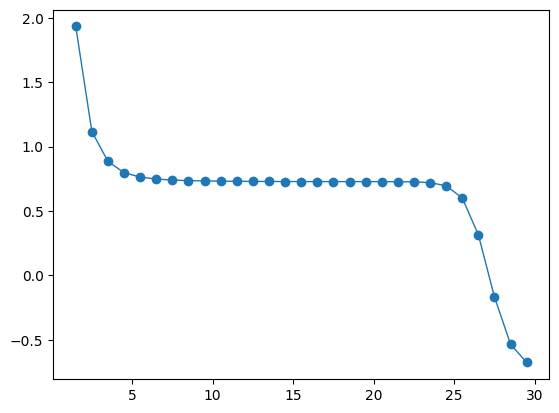

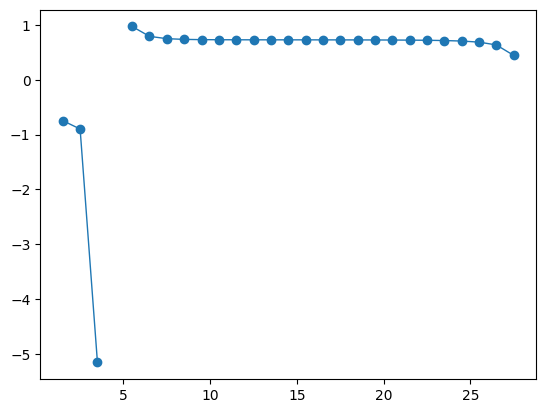

In [35]:
times = np.arange(0,tvals)
eff_mass_times = times[:-1]+0.5

plt.plot(eff_mass_times,np.mean(eff_mass_x,axis=0),'-o',linewidth=1)

plt.figure()
plt.plot(eff_mass_times,np.mean(eff_mass_z,axis=0),'-o',linewidth=1)

Text(0.5, 1.0, 'cut = 5')

<Figure size 640x480 with 0 Axes>

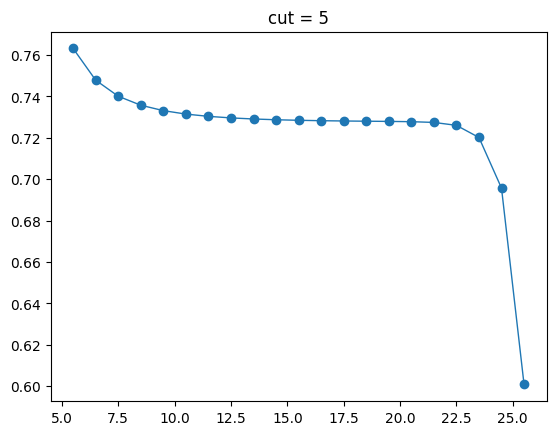

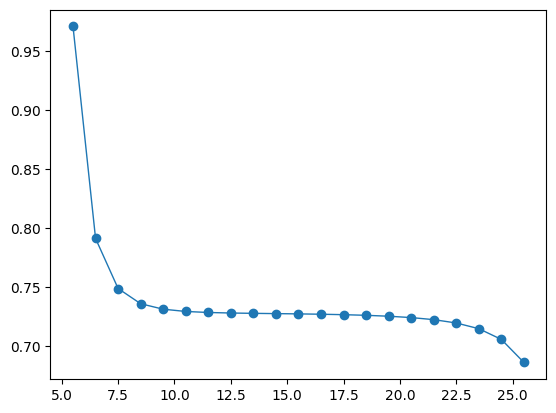

In [36]:
times = np.arange(0,tvals)
eff_mass_times = times[:-1]+0.5

cut = 5

plt.title(f"cut = {cut}")

plt.plot(eff_mass_times[cut:-cut],np.mean(eff_mass_x,axis=0)[cut:-cut],'-o',linewidth=1)

plt.figure()
plt.plot(eff_mass_times[cut:-cut],np.mean(eff_mass_z,axis=0)[cut:-cut],'-o',linewidth=1)

Text(0.5, 1.0, 'cut = 8')

<Figure size 640x480 with 0 Axes>

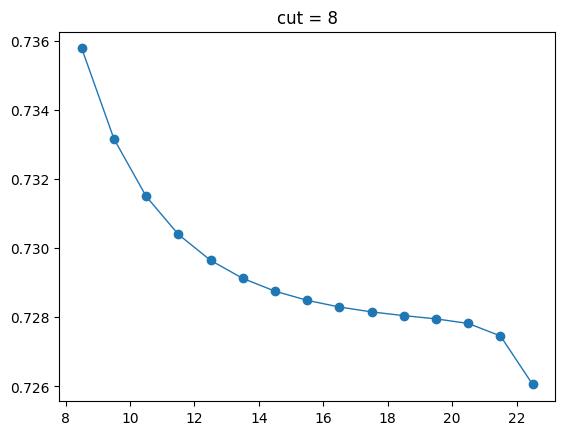

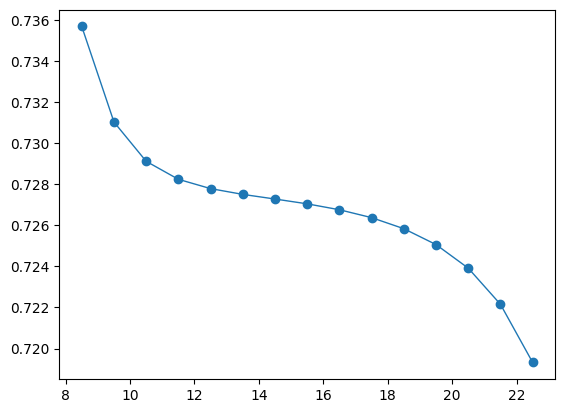

In [37]:
times = np.arange(0,tvals)
eff_mass_times = times[:-1]+0.5

cut = 8

plt.title(f"cut = {cut}")

plt.plot(eff_mass_times[cut:-cut],np.mean(eff_mass_x,axis=0)[cut:-cut],'-o',linewidth=1)

plt.figure()
plt.plot(eff_mass_times[cut:-cut],np.mean(eff_mass_z,axis=0)[cut:-cut],'-o',linewidth=1)

## Mass estimate

In [38]:
cut = 8

eff_mass_x_aver = np.mean( eff_mass_x[:,cut:-cut] , axis=1 )
eff_mass_z_aver = np.mean( eff_mass_z[:,cut:-cut] , axis=1 )

if verbose:
    print("(nconf,)")
    print(np.shape(eff_mass_x_aver))
    print(np.shape(eff_mass_z_aver))

(nconf,)
(914,)
(914,)


In [39]:
#using the jackknife
data = eff_mass_x_aver

test_statistic = np.mean
            
estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)
            
print(estimate,bias,stderr,conf_interval)


data = eff_mass_z_aver

test_statistic = np.mean
            
estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)
            
print(estimate,bias,stderr,conf_interval)

0.7293747444338029 0.0 2.5081902095656722e-06 [0.72936983 0.72937966]
0.7268709046893909 0.0 2.6312036938130064e-06 [0.72686575 0.72687606]


## mass estimate with jack

In [40]:
times = np.arange(0,tvals)
eff_mass_times = times[:-1]+0.5

test_statistic = np.mean

eff_mass_x_jack = []
eff_mass_x_jack_std = []
eff_mass_z_jack = []
eff_mass_z_jack_std = []

for t in range(tvals-1):

    data = eff_mass_x[:,t]

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    eff_mass_x_jack.append(estimate)
    eff_mass_x_jack_std.append(stderr)

    data = eff_mass_z[:,t]

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    eff_mass_z_jack.append(estimate)
    eff_mass_z_jack_std.append(stderr)

eff_mass_x_jack = np.array(eff_mass_x_jack)
eff_mass_x_jack_std = np.array(eff_mass_x_jack_std)
eff_mass_z_jack = np.array(eff_mass_z_jack)
eff_mass_z_jack_std = np.array(eff_mass_z_jack_std)

/home/tag-e/università/Magistrale/tesi/codice/myCode/python_analysis/my_env/lib/python3.10/site-packages/astropy/stats/jackknife.py:163: RuntimeWarning: invalid value encountered in scalar subtract
  bias = (n - 1) * (mean_jack_stat - stat_data)
/home/tag-e/università/Magistrale/tesi/codice/myCode/python_analysis/my_env/lib/python3.10/site-packages/astropy/stats/jackknife.py:168: RuntimeWarning: invalid value encountered in subtract
  * np.mean((jack_stat - mean_jack_stat) * (jack_stat - mean_jack_stat), axis=0)


In [41]:
eff_mass_x_jack_std/eff_mass_x_jack

array([            nan,  2.42860544e-04,  2.82081723e-04,  1.88077218e-04,
        1.04444877e-04,  5.89563492e-05,  3.54329680e-05,  2.25586795e-05,
        1.50019721e-05,  1.02960754e-05,  7.22946117e-06,  5.16215096e-06,
        3.73267738e-06,  2.72507634e-06,  2.00430359e-06,  1.48277719e-06,
        1.10201461e-06,  8.22039443e-07,  6.15006901e-07,  4.61231778e-07,
        3.46651006e-07,  2.61205358e-07,  1.97930290e-07,  1.52919300e-07,
        1.27190604e-07,  1.34419264e-07,  2.55357858e-07, -3.30876060e-07,
       -3.62953894e-08, -6.14128151e-09,             nan])

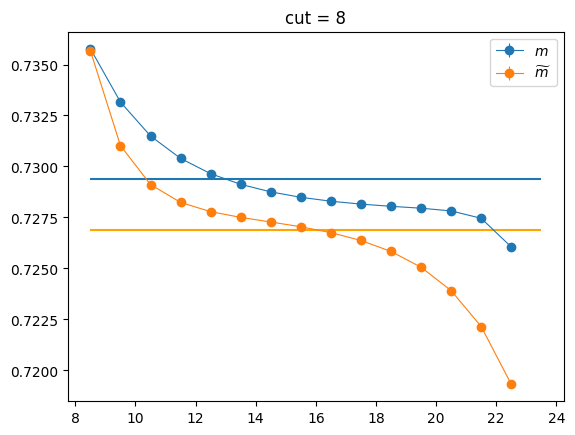

In [42]:
cut = 8
_ = plt.title(f"cut = {cut}")
_ = plt.errorbar(eff_mass_times[cut:-cut],eff_mass_x_jack[cut:-cut],yerr=eff_mass_x_jack_std[cut:-cut],marker='o',linewidth = 0.8,label=r'$m$')
_ = plt.errorbar(eff_mass_times[cut:-cut],eff_mass_z_jack[cut:-cut],yerr=eff_mass_z_jack_std[cut:-cut],marker='o',linewidth = 0.8,label=r'$\widetilde{m}$')
_ = plt.legend()


m_from_jack = np.mean(eff_mass_x_jack[cut:-cut])
mt_from_jack = np.mean(eff_mass_z_jack[cut:-cut])


_ = plt.hlines(m_from_jack,eff_mass_times[cut],eff_mass_times[-cut])
_ = plt.hlines(mt_from_jack,eff_mass_times[cut],eff_mass_times[-cut],color='orange')


In [43]:
print(f"m  = {m_from_jack}")
print(f"mt = {mt_from_jack}")

m  = 0.7293747444338098
mt = 0.7268709046893842


## Mass sinh Fit

### Jackknife

In [47]:
test_statistic = np.mean

corr_x_navg_jack = np.empty(shape=(tvals),dtype=float)
corr_x_navg_jack_std = np.empty(shape=(tvals),dtype=float)
corr_z_navg_jack = np.empty(shape=(tvals),dtype=float)
corr_z_navg_jack_std = np.empty(shape=(tvals),dtype=float)


for t in range(tvals):

    data = corr_x_navg[:,t].real

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corr_x_navg_jack[t] = estimate
    corr_x_navg_jack_std[t] = stderr

    if np.abs(bias/estimate)>10**-10:
        print(f"x / {t} / {bias}")



    data = corr_z_navg[:,t].real

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corr_z_navg_jack[t] = estimate
    corr_z_navg_jack_std[t] = stderr

    if np.abs(bias/estimate)>10**-10:
        print(f"z / {t} / {bias}")

/tmp/ipykernel_64357/3051873958.py:18: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(bias/estimate)>10**-10:
/tmp/ipykernel_64357/3051873958.py:30: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(bias/estimate)>10**-10:


<ErrorbarContainer object of 3 artists>

<Figure size 640x480 with 0 Axes>

<ErrorbarContainer object of 3 artists>

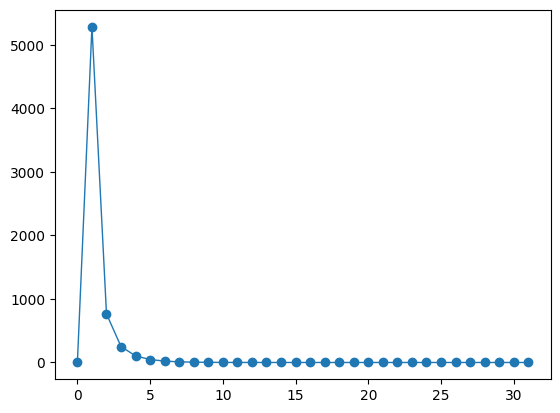

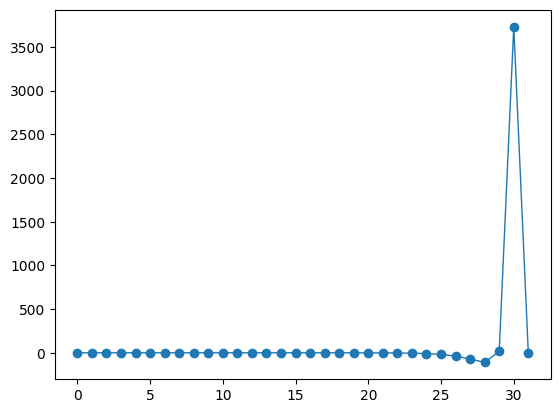

In [48]:
times = np.arange(tvals)

plt.errorbar(times,corr_x_navg_jack,yerr=corr_x_navg_jack_std,marker='o',linewidth=1)

plt.figure()

plt.errorbar(times,corr_z_navg_jack,yerr=corr_z_navg_jack_std,marker='o',linewidth=1)

Text(0.5, 1.0, 'cut = 8')

<ErrorbarContainer object of 3 artists>

<Figure size 640x480 with 0 Axes>

<ErrorbarContainer object of 3 artists>

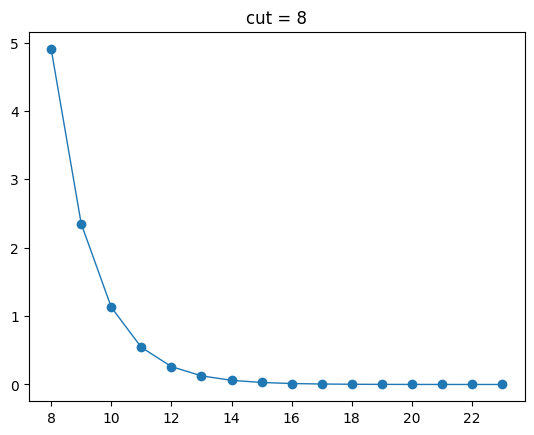

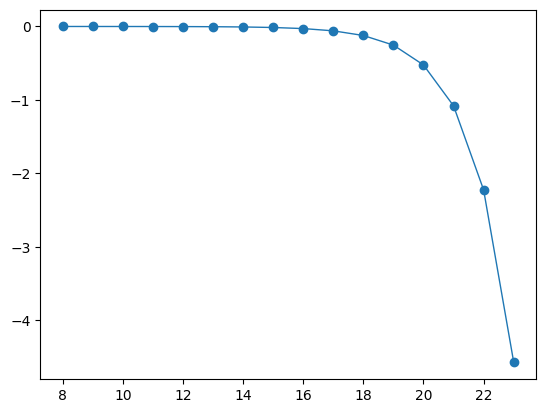

In [49]:
times = np.arange(tvals)

cut = 8

plt.title(f"cut = {cut}")

plt.errorbar(times[cut:-cut],corr_x_navg_jack[cut:-cut],yerr=corr_x_navg_jack_std[cut:-cut],marker='o',linewidth=1)

plt.figure()

plt.errorbar(times[cut:-cut],corr_z_navg_jack[cut:-cut],yerr=corr_z_navg_jack_std[cut:-cut],marker='o',linewidth=1)

### fit with scipy

In [51]:
def chi2(result,data,data_std):
    return np.sum( ((result-data)/data_std)**2 )

In [52]:
guess_mass_x = 0.42
guess_amp_x =  corr_x_navg_jack[4]

def fit_sinh_x(t,amp,mass):
    return amp*np.sinh(mass*(tvals-1-t)) #tvals-1 because T=tvals-1


guess_mass_z = 0.42
guess_amp_z =  corr_x_navg_jack[-4]

def fit_sinh_z(t,amp,mass):
    return amp*np.sinh(mass*t)

In [53]:
#cut  = 12
cut = 8

fit_times_x = times[cut:-cut]
fit_times_z = times[cut:-cut]

fit_data_x = corr_x_navg_jack[cut:-cut]
fit_data_z = corr_z_navg_jack[cut:-cut]

guess_x = [guess_amp_x,guess_mass_x]
guess_z = [guess_amp_z,guess_mass_z]

In [54]:
popt_x,pcov_x = curve_fit(fit_sinh_x, fit_times_x, fit_data_x, p0=guess_x)
perr_x = np.sqrt(np.diag(pcov_x))
fit_result_x = fit_sinh_x(fit_times_x,*popt_x)

popt_z,pcov_z = curve_fit(fit_sinh_z, fit_times_z, fit_data_z, p0=guess_z)
perr_z = np.sqrt(np.diag(pcov_z))
fit_result_z = fit_sinh_z(fit_times_z,*popt_z)

In [55]:
print("Result x:")
print(f"amp:  {popt_x[0]} +- {perr_x[0]}")
print(f"mass: {popt_x[1]} +- {perr_x[1]}\n")

print("Result z:")
print(f"amp:  {popt_z[0]} +- {perr_z[0]}")
print(f"mass: {popt_z[1]} +- {perr_z[1]}\n")

Result x:
amp:  4.5267610100283824e-07 +- 3.3763595187632794e-09
mass: 0.7344175186174693 +- 0.0003284376928586176

Result z:
amp:  -5.765822479379157e-07 +- 4.641859593809543e-09
mass: 0.720823450493005 +- 0.00035466774378673096



chi2: 12425.64214525525


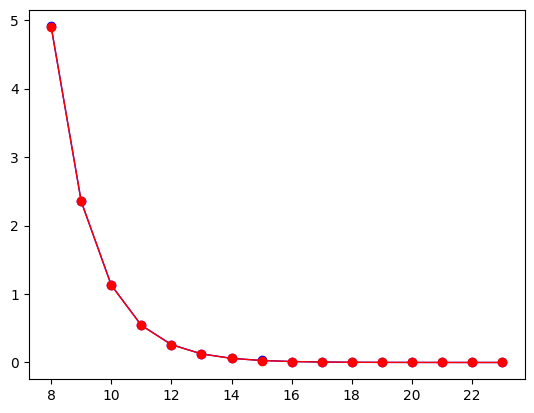

In [56]:
plt.plot(fit_times_x,fit_data_x,'-o',label='data',color='blue',linewidth=1)
plt.plot(fit_times_x,fit_result_x,'-o',label='fit',color='red',linewidth=1)

print(f"chi2: {chi2(fit_result_x,fit_data_x,corr_x_navg_jack_std[cut:-cut])}")

chi2: 17090.0914387599


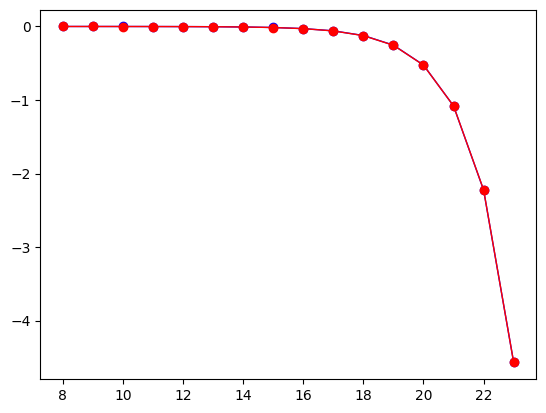

In [57]:
plt.plot(fit_times_z,fit_data_z,'-o',label='data',color='blue',linewidth=1)
plt.plot(fit_times_z,fit_result_z,'-o',label='fit',color='red',linewidth=1)

print(f"chi2: {chi2(fit_result_z,fit_data_z,corr_z_navg_jack_std[cut:-cut])}")

## Intermediate results

In [58]:
mps = popt_x[1]
mps_err = perr_x[1]

mpst = popt_z[1]
mpst_err = perr_z[1]

print(f"m_ps       = {round(mps,5)} +- {round(mps_err,5)}")
print(f"m_ps_tilda = {round(mpst,5)} +- {round(mpst_err,5)}")

m_ps       = 0.73442 +- 0.00033
m_ps_tilda = 0.72082 +- 0.00035


# 3 point func study

## reading

In [59]:
dirName = '../../data_from_scp/'
name = 'odd_run18.odd_df2_4fop'
datName = name + '.dat'

fileName = dirName + datName

In [60]:
noperators=5 #number of operators (VA - AV - SP - PS - TT~)

verbose=True #True to print more output

step = 1 #steps at which configurations are read

early_stop = 0

In [61]:
#the correlators array will be stored in a dict having as keys the configurations
conf_dict = {}
conf_dict_2p = {}

#list with configurations number
conf_num_list = []

##### reading data from binary dat file #####
with open(fileName, mode='rb') as file: # b is important -> binary
    fileContent = file.read()

    #header is made up of 5 integers, 5x4=20byte, and 2 double, 2x8=16byte
    header_size= 6*4 +2*8

    #first 16 byte are four 4-byte integers
    ncorr, nnoise, tvals, noise_type, check_gauge_inv, random_conf, csw, cf = struct.unpack("iiiiiidd", fileContent[:header_size])

    #initialization of correlators' variables
    k1=['']*ncorr
    k2=['']*ncorr
    k3=['']*ncorr
    k4=['']*ncorr
    mu1=['']*ncorr
    mu2=['']*ncorr
    mu3=['']*ncorr
    mu4=['']*ncorr
    typeA=['']*ncorr
    typeB=['']*ncorr
    x0=['']*ncorr
    z0=['']*ncorr

    
    #each correlator has an header of size given by 8x8 + 4x4 = 80byte
    corr_header_size = 8*8 + 4*4
    
    #then there are ncorr block, 8x8 + 4x4 (8 double and 4 int) with the following structure 
    for i in range(ncorr):
         k1[i], k2[i], k3[i], k4[i], mu1[i], mu2[i], mu3[i], mu4[i], typeA[i], typeB[i], x0[i], z0[i] = struct.unpack("ddddddddiiii",fileContent[header_size+corr_header_size*i:header_size+corr_header_size*(i+1)])



    #initialization of correlators array
    conn_corr = np.empty(shape=(ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #connected correlators
    disc_corr = np.empty(shape=(ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #disconnected correlators

    x_corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex)
    z_corr = np.empty(shape=(ncorr,tvals,nnoise),dtype=complex)


    #offset due to 3 points (see comment below)
    offset_3point = nnoise    *   nnoise   *  tvals                  * noperators        * 2                                    * 2         * 8 
    offset_2point = nnoise * tvals * 2                   * 2         * 8

    offset_diag3 = nnoise    *   nnoise   *  tvals                  * noperators        * 2         * 8
    offset_diag2 = nnoise * tvals                   * 2         * 8

    #configuration start right after the header
    first_conf = header_size+corr_header_size*ncorr
    
    #we compute the lenght of the data block for each configuration
    #          nnoise_A  *  nnoise_B  *  time lenght of lattice * noperators   * ncorrelators * 2 (diagrams=connected+disconnected)  * 2 (re+im) * 8 (sizeof(double))  + sizeof(int) (= conf_number)
    conf_len = nnoise    *   nnoise   *  tvals                  * noperators   * ncorr        * 2                                    * 2         * 8                    + 4
    #                     ncorr * nnoise * tvaks * 2 (x+z 2point corr) * 2 (re+im) * 8 (sizeof(double))
    conf_len = conf_len + ncorr * nnoise * tvals * 2                   * 2         * 8

    #starting right after the header we read each configuration block
    for start_conf in range(first_conf, len(fileContent)-conf_len*early_stop, conf_len*step):
    #for start_conf in range(first_conf, len(fileContent)-conf_len, conf_len):

        #breaks loop if the file does not contain the whole correlator for the given configuration
        if start_conf+conf_len > len(fileContent) :
            break

        #reading of the configuration number
        conf_number = struct.unpack("i",fileContent[start_conf:start_conf+4])[0]
        if verbose==True:
            print(f"Reading: Gauge Conf = {conf_number}\n")

        #store of conf num
        if conf_number not in conf_num_list:
            conf_num_list.append(conf_number)

        #initialize to 0 the array storing the correlators
        conn_corr.fill(complex(0,0))
        disc_corr.fill(complex(0,0))
        #same for 2 point
        x_corr.fill(complex(0,0))
        z_corr.fill(complex(0,0))

        start_reading = start_conf+4

        #loop over the correlators (ncorr blocks of...)
        for ic in range(ncorr):

            #reading of chunk with conn corr
            
            #loop over the operators (...noperators blocs of...)
            for op in range(noperators):
                #loop over time values (...tvals blocks of...)
                for t in range(tvals):
                    #loop over noiseB vectors (...nnoise blocks of...)
                    for noiseB in range(nnoise):
                        #loop over noiseA vectors (...nnoise blocks of...)
                        for noiseA in range(nnoise):
                    
                            #reading of re and im part of correlators   (...complex numbers)
                            
                            #connected correlators

                            #begin of reading point (8=sizeof(double)) (last 2 is number of diagrams)
                            #start_reading = start_conf+4 + 2*8*noiseA+2*8*nnoise*(noiseB+nnoise*(t+tvals*(op+noperators*2*ic)))
                            
                            #reading of real and complex for connected corr
                            re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])

                            #store complex number
                            conn_corr[ic][op][t][noiseB][noiseA] = complex(re,im)


                            #disconnected correlators

                            #begin of reading point (8=sizeof(double)) (last 2 is number of diagrams)
                            #start_reading = start_conf+4 + 2*8*noiseA+2*8*nnoise*(noiseB+nnoise*(t+tvals*(op+noperators*(2*ic+1))))

                            #reading of real and complex for connected corr
                            #re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                            re,im = struct.unpack("dd",fileContent[start_reading+offset_diag3:start_reading+offset_diag3+16])

                            #store complex number
                            disc_corr[ic][op][t][noiseB][noiseA] = complex(re,im)

                            #update start reading
                            start_reading = start_reading+16

                            ############# new reading #########

                            #start_reading  = start_conf + 4 + 2 * 2*8 * (noiseA + nnoise*(noiseB + nnoise*(t + tvals*(op + noperators*ic ) ) ) )

                            #re_con, im_con, re_disc, im_disc = struct.unpack("dddd",fileContent[start_reading:start_reading+2*2*8])
                            #conn_corr[ic,op,t,noiseB,noiseA] = complex(re_con,im_con)
                            #disc_corr[ic,op,t,noiseB,noiseA] = complex(re_disc,im_disc)

            #update start reading for the disconnected part
            start_reading = start_reading + offset_diag3
            
            if(ic==0):
                print(start_reading+16)
            
            #reading of 2 point functions
            for t in range(tvals):
                for inoise in range(nnoise):
                    #start_reading = start_conf + 4 + offset_3point + 2*8*(inoise+nnoise*(t+tvals*2*ic)) #last 2 is for 2point in x and z
                    re,im = struct.unpack("dd",fileContent[start_reading:start_reading+16])
                    x_corr[ic][t][inoise] = complex(re,im)
                    #start_reading = start_conf + 4 + offset_3point + 2*8*(inoise+nnoise*(t+tvals*(2*ic+1))) 
                    re,im = struct.unpack("dd",fileContent[start_reading+offset_diag2:start_reading+offset_diag2+16])
                    z_corr[ic][t][inoise] = complex(re,im)

                    #update start reading
                    start_reading = start_reading+16
            #update start reading for the 2point with source in z
            start_reading = start_reading + offset_diag2

        #store of correlators associated to the given configuration
        if str(conf_number) not in conf_dict.keys():
            conf_dict[str(conf_number)] = (conn_corr.copy(),disc_corr.copy())
            conf_dict_2p[str(conf_number)] = (x_corr.copy(),z_corr.copy())
        else:
            conf_dict[str(conf_number)+"_GaugeInvCheck"] = (conn_corr.copy(),disc_corr.copy())
            conf_dict_2p[str(conf_number)+"_GaugeInvCheck"] = (x_corr.copy(),z_corr.copy())

Reading: Gauge Conf = 1

1152140
Reading: Gauge Conf = 2

2319504
Reading: Gauge Conf = 3

3486868
Reading: Gauge Conf = 4

4654232
Reading: Gauge Conf = 5

5821596
Reading: Gauge Conf = 6

6988960
Reading: Gauge Conf = 7

8156324
Reading: Gauge Conf = 8

9323688
Reading: Gauge Conf = 9

10491052
Reading: Gauge Conf = 10

11658416
Reading: Gauge Conf = 11

12825780
Reading: Gauge Conf = 12

13993144
Reading: Gauge Conf = 13

15160508
Reading: Gauge Conf = 14

16327872
Reading: Gauge Conf = 15

17495236
Reading: Gauge Conf = 16

18662600
Reading: Gauge Conf = 17

19829964
Reading: Gauge Conf = 18

20997328
Reading: Gauge Conf = 19

22164692
Reading: Gauge Conf = 20

23332056
Reading: Gauge Conf = 21

24499420
Reading: Gauge Conf = 22

25666784
Reading: Gauge Conf = 23

26834148
Reading: Gauge Conf = 24

28001512
Reading: Gauge Conf = 25

29168876
Reading: Gauge Conf = 26

30336240
Reading: Gauge Conf = 27

31503604
Reading: Gauge Conf = 28

32670968
Reading: Gauge Conf = 29

33838332
Re

In [62]:
#check on correct lenght calculations
(len(fileContent)-header_size-corr_header_size*ncorr)/(offset_3point+offset_2point+4)

991.0

In [63]:
#construction of array with names and numbers of configurations
conf_names = list(conf_dict.keys())[0::1+check_gauge_inv]
conf_list = [int(conf) for conf in conf_names ]
nconf = len(conf_list)

In [64]:
#creation of a numpy array with all the correlators
all_correlators = np.empty(shape=(nconf,2,ncorr,noperators,tvals,nnoise,nnoise),dtype=complex) #2 is for connected and disconnected
for iconf,nameconf in enumerate(conf_names):
    all_correlators[iconf] = conf_dict[nameconf]

In [65]:
if verbose:
    print("(nconf, pieces, ncorrelators, noperators, tvals, nnoise, nnoise)")
    print(np.shape(all_correlators))

(nconf, pieces, ncorrelators, noperators, tvals, nnoise, nnoise)
(991, 2, 1, 5, 32, 15, 15)


In [66]:
#analogous for 2 points func
all_2point_x = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
all_2point_z = np.empty(shape=(nconf,ncorr,tvals,nnoise),dtype=complex)
for iconf,nameconf in enumerate(conf_names):
    all_2point_x[iconf] = conf_dict_2p[nameconf][0]
    all_2point_z[iconf] = conf_dict_2p[nameconf][1]


if verbose:
    print("(nconf, ncorrelators, tvals, nnoise)")
    print(np.shape(all_2point_x))
    print(np.shape(all_2point_z))

(nconf, ncorrelators, tvals, nnoise)
(991, 1, 32, 15)
(991, 1, 32, 15)


## data to be used

In [67]:
#for the 2 points
#corr_x_navg
#corr_z_navg

nconf = np.shape(corr_x_navg)[0]

corr_3p = all_correlators[:nconf,0,0,:,:,:,:] + all_correlators[:nconf,1,0,:,:,:,:]
corr_3p_navg = corr_3p.mean(axis=-1).mean(axis=-1)


if verbose:
    print("(nconf',tvals)")
    print(np.shape(corr_x_navg))
    print(np.shape(corr_z_navg))
    print("(nconf,noperators,tvals)")
    print(np.shape(corr_3p_navg))

(nconf',tvals)
(914, 32)
(914, 32)
(nconf,noperators,tvals)
(914, 5, 32)


In [68]:
#jackknife
test_statistic = np.mean

corr_x_navg_jack = np.empty(shape=(tvals),dtype=float)
corr_x_navg_jack_std = np.empty(shape=(tvals),dtype=float)
corr_z_navg_jack = np.empty(shape=(tvals),dtype=float)
corr_z_navg_jack_std = np.empty(shape=(tvals),dtype=float)
corr_3p_navg_jack = np.empty(shape=(noperators,tvals),dtype=float)
corr_3p_navg_jack_std = np.empty(shape=(noperators,tvals),dtype=float)


for t in range(tvals):

    data = corr_x_navg[:,t].real

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corr_x_navg_jack[t] = estimate
    corr_x_navg_jack_std[t] = stderr

    if np.abs(bias/estimate)>10**-10:
        print(f"x / {t} / {bias}")



    data = corr_z_navg[:,t].real

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corr_z_navg_jack[t] = estimate
    corr_z_navg_jack_std[t] = stderr

    if np.abs(bias/estimate)>10**-10:
        print(f"z / {t} / {bias}")

    for iop in range(noperators):

        data = corr_3p_navg[:,iop,t].imag

        estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

        corr_3p_navg_jack[iop,t] = estimate
        corr_3p_navg_jack_std[iop,t] = stderr

        if np.abs(bias/estimate)>10**-10:
            print(f"3p / {iop} / {t} / {bias}")



if verbose:
    print("(tvals)")
    print(np.shape(corr_x_navg_jack))
    print(np.shape(corr_z_navg_jack))
    print("(noperators,tvals)")
    print(np.shape(corr_3p_navg_jack))

/tmp/ipykernel_64357/851436603.py:21: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(bias/estimate)>10**-10:
/tmp/ipykernel_64357/851436603.py:33: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(bias/estimate)>10**-10:
/tmp/ipykernel_64357/851436603.py:45: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(bias/estimate)>10**-10:


(tvals)
(32,)
(32,)
(noperators,tvals)
(5, 32)


## amplitude extraction (hopefully)

In [69]:
def final_func(t,m,m_tilda):
    return 2 * np.exp(-(m+m_tilda)) * ( np.cosh((m+m_tilda)*t) - np.cosh((m-m_tilda)*t) )

In [53]:
'''
element1 = np.empty(shape=(noperators,tvals),dtype=float)
element2 = np.empty(shape=(noperators,tvals),dtype=float)
result = np.empty(shape=(noperators,tvals),dtype=float)
mat_ele_squared = np.empty(shape=(noperators,tvals),dtype=float)
mat_ele = np.empty(shape=(noperators,tvals),dtype=float)

func_factor = np.empty(shape=(tvals),dtype=float)
func_factor = final_func(times,mps,mpst)


for iop in range(noperators):

    element1[iop,:] = corr_3p_navg_jack[iop,:]/corr_z_navg_jack[:]

    element2[iop,:] = corr_3p_navg_jack[iop,::-1]/corr_x_navg_jack[::-1]

    #result[iop,:] = element1[iop,:] * np.conjugate(element2[iop,:])
    result[iop,:] = element1[iop,:] * (-element2[iop,:]) #since the three point is fully imaginary conjugation equals a minus overall

    mat_ele_squared[iop,:] = result[iop,:] * func_factor[:]

    mat_ele[iop,:]  = np.sqrt(mat_ele_squared[iop,:] )
'''

/tmp/ipykernel_55056/147724910.py:13: RuntimeWarning: invalid value encountered in divide
  element1[iop,:] = corr_3p_navg_jack[iop,:]/corr_z_navg_jack[:]
/tmp/ipykernel_55056/147724910.py:15: RuntimeWarning: invalid value encountered in divide
  element2[iop,:] = corr_3p_navg_jack[iop,::-1]/corr_x_navg_jack[::-1]
/tmp/ipykernel_55056/147724910.py:22: RuntimeWarning: invalid value encountered in sqrt
  mat_ele[iop,:]  = np.sqrt(mat_ele_squared[iop,:] )


In [70]:
mat_ele = np.empty(shape=(noperators,tvals),dtype=float)

for iop in range(noperators):
    for t in range(tvals):
        e1 = corr_3p_navg_jack[iop,t]/corr_z_navg_jack[t]
        e2 = corr_3p_navg_jack[iop,tvals-1-t]/corr_x_navg_jack[tvals-1-t]
        mat_ele[iop,t] = np.sqrt(  e1* (-e2) * final_func(t,mps,mpst) ) 

/tmp/ipykernel_64357/2719963908.py:5: RuntimeWarning: invalid value encountered in scalar divide
  e1 = corr_3p_navg_jack[iop,t]/corr_z_navg_jack[t]
/tmp/ipykernel_64357/2719963908.py:6: RuntimeWarning: invalid value encountered in scalar divide
  e2 = corr_3p_navg_jack[iop,tvals-1-t]/corr_x_navg_jack[tvals-1-t]
/tmp/ipykernel_64357/2719963908.py:7: RuntimeWarning: invalid value encountered in sqrt
  mat_ele[iop,t] = np.sqrt(  e1* (-e2) * final_func(t,mps,mpst) )


In [71]:
mat_ele

array([[          nan,           nan,           nan,           nan,
                  nan,  273.54610478,  247.1787419 ,  238.84240294,
         235.94506747,  234.85146286,  234.53814575,  234.56795866,
         235.24133971,  236.07265071,  235.75412676,  235.41751369,
         235.38329146,  235.64903401,  235.88834585,  234.96037276,
         234.15164353,  233.90425832,  233.82950685,  234.17550168,
         235.53423685,  240.20882861,  251.6783963 ,  279.60191862,
         362.02755107,           nan,           nan,           nan],
       [          nan,           nan,           nan,           nan,
                  nan,  194.53195174,  175.84781784,  169.48953578,
         167.73802079,  167.21487344,  166.41219064,  166.07216048,
         166.96522552,  167.97485163,  168.15659619,  168.18192235,
         168.15747404,  168.08163657,  167.84371157,  166.76580603,
         165.77741283,  165.96242757,  166.48723802,  166.48000143,
         167.14196463,  170.88928446,  178.9807

In [54]:
'''
#alternative with tvals-1
element1 = np.empty(shape=(noperators,tvals-1),dtype=float)
element2 = np.empty(shape=(noperators,tvals-1),dtype=float)
result = np.empty(shape=(noperators,tvals-1),dtype=float)
mat_ele_squared = np.empty(shape=(noperators,tvals-1),dtype=float)
mat_ele = np.empty(shape=(noperators,tvals-1),dtype=float)

func_factor = np.empty(shape=(tvals-1),dtype=float)
func_factor = final_func(times,mps,mpst)


for iop in range(noperators):

    element1[iop,:] = corr_3p_navg_jack[iop,:-1]/corr_z_navg_jack[:-1]

    element2[iop,:] = corr_3p_navg_jack[iop,-2::-1]/corr_x_navg_jack[-2::-1]

    result[iop,:] = element1[iop,:] * np.conjugate(element2[iop,:])

    mat_ele_squared[iop,:] = -result[iop,:] * func_factor[:-1]

    mat_ele[iop,:]  = np.sqrt(mat_ele_squared[iop,:] )
    '''

'\n#alternative with tvals-1\nelement1 = np.empty(shape=(noperators,tvals-1),dtype=float)\nelement2 = np.empty(shape=(noperators,tvals-1),dtype=float)\nresult = np.empty(shape=(noperators,tvals-1),dtype=float)\nmat_ele_squared = np.empty(shape=(noperators,tvals-1),dtype=float)\nmat_ele = np.empty(shape=(noperators,tvals-1),dtype=float)\n\nfunc_factor = np.empty(shape=(tvals-1),dtype=float)\nfunc_factor = final_func(times,mps,mpst)\n\n\nfor iop in range(noperators):\n\n    element1[iop,:] = corr_3p_navg_jack[iop,:-1]/corr_z_navg_jack[:-1]\n\n    element2[iop,:] = corr_3p_navg_jack[iop,-2::-1]/corr_x_navg_jack[-2::-1]\n\n    result[iop,:] = element1[iop,:] * np.conjugate(element2[iop,:])\n\n    mat_ele_squared[iop,:] = -result[iop,:] * func_factor[:-1]\n\n    mat_ele[iop,:]  = np.sqrt(mat_ele_squared[iop,:] )\n    '

In [74]:
#mat_ele_squared

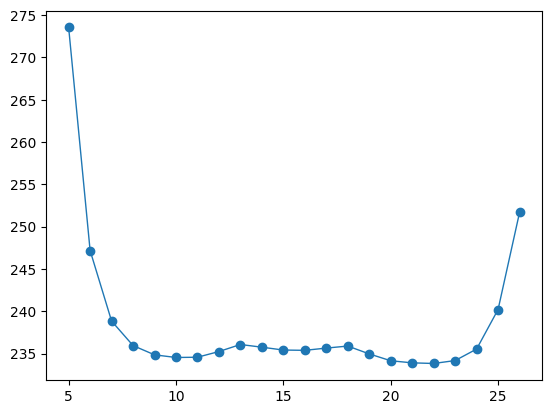

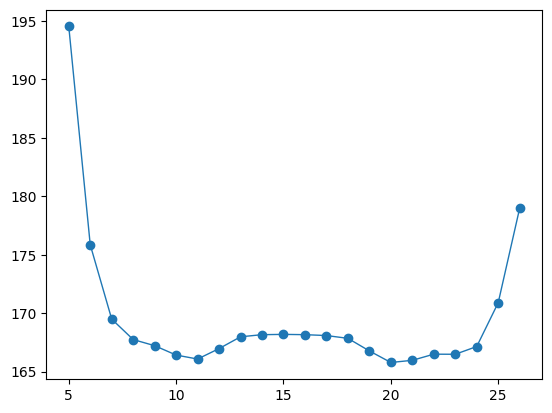

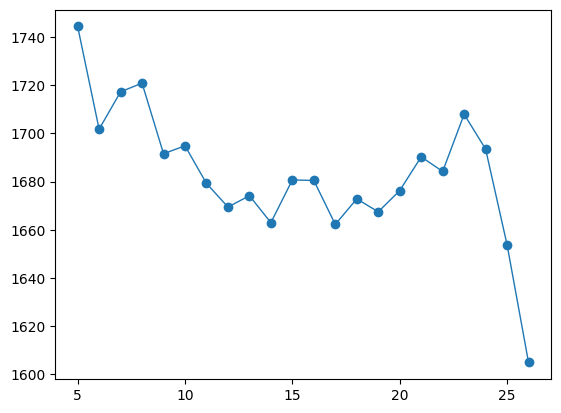

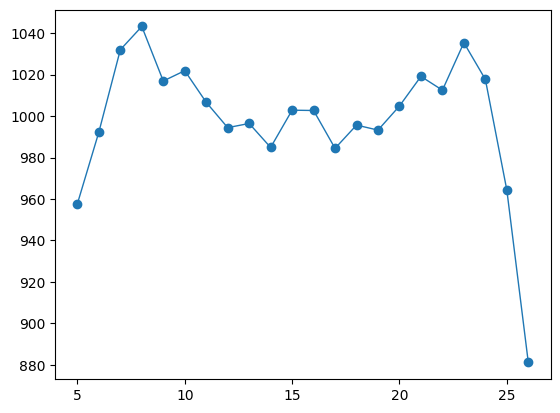

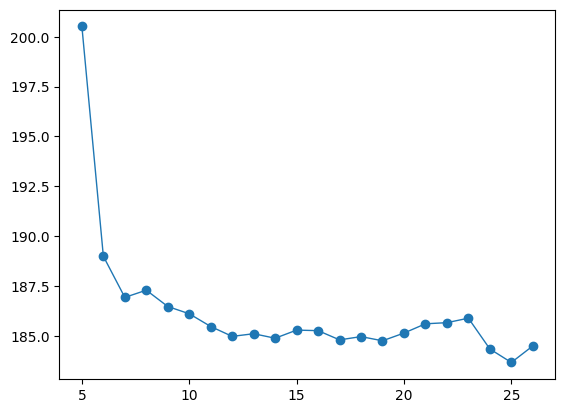

In [72]:
times = np.arange(tvals)

cut = 5

for iop in range(noperators):
    _ = plt.figure()
    _ = plt.plot(times[cut:-cut],mat_ele[iop,cut:-cut],'-o',linewidth=1)

In [73]:
mat_ele_avg = [mat_ele[iop,cut:-cut].mean() for iop in range(noperators)]


mat_ele_avg

[238.51449688332124,
 169.5978574208396,
 1683.2456434849148,
 998.179960198963,
 186.20069552112318]

## analysis conf per conf

In [58]:
'''
element1 = np.empty(shape=(nconf,noperators,tvals),dtype=float)
element2 = np.empty(shape=(nconf,noperators,tvals),dtype=float)
result = np.empty(shape=(nconf,noperators,tvals),dtype=float)
mat_ele_squared = np.empty(shape=(nconf,noperators,tvals),dtype=float)
mat_ele = np.empty(shape=(nconf,noperators,tvals),dtype=float)

func_factor = np.empty(shape=(tvals),dtype=float)
func_factor = final_func(times,mps,mpst)


for iconf in range(nconf):
    for iop in range(noperators):

        element1[iconf,iop,:] = corr_3p_navg[iconf,iop,:].imag/corr_z_navg[iconf,:].real

        element2[iconf,iop,:] = corr_3p_navg[iconf,iop,::-1].imag/corr_x_navg[iconf,::-1].real

        #result[iconf,iop,:] = element1[iconf,iop,:] * np.conjugate(element2[iconf,iop,:])
        result[iconf,iop,:] = element1[iconf,iop,:] * ( - element2[iconf,iop,:] )

        mat_ele_squared[iconf,iop,:] = result[iconf,iop,:] * func_factor[:]

        mat_ele[iconf,iop,:]  = np.sqrt(mat_ele_squared[iconf,iop,:] )
'''

/tmp/ipykernel_55056/1797462963.py:14: RuntimeWarning: invalid value encountered in divide
  element1[iconf,iop,:] = corr_3p_navg[iconf,iop,:].imag/corr_z_navg[iconf,:].real
/tmp/ipykernel_55056/1797462963.py:16: RuntimeWarning: invalid value encountered in divide
  element2[iconf,iop,:] = corr_3p_navg[iconf,iop,::-1].imag/corr_x_navg[iconf,::-1].real
/tmp/ipykernel_55056/1797462963.py:23: RuntimeWarning: invalid value encountered in sqrt
  mat_ele[iconf,iop,:]  = np.sqrt(mat_ele_squared[iconf,iop,:] )


In [81]:
mat_ele = np.empty(shape=(nconf,noperators,tvals),dtype=float)

for iconf in range(nconf):
    for iop in range(noperators):
        for t in range(tvals):
            e1 = corr_3p_navg[iconf,iop,t].imag/corr_z_navg[iconf,t].real
            e2 = corr_3p_navg[iconf,iop,tvals-1-t].imag/corr_x_navg[iconf,tvals-1-t].real
            #mat_ele[iconf,iop,t] = np.sqrt( e1* (-e2) * final_func(t,mps,mpst) )
            mat_ele[iconf,iop,t] =  e1* (-e2) * final_func(t,mps,mpst) 

/tmp/ipykernel_64357/2230063672.py:6: RuntimeWarning: invalid value encountered in scalar divide
  e1 = corr_3p_navg[iconf,iop,t].imag/corr_z_navg[iconf,t].real
/tmp/ipykernel_64357/2230063672.py:7: RuntimeWarning: invalid value encountered in scalar divide
  e2 = corr_3p_navg[iconf,iop,tvals-1-t].imag/corr_x_navg[iconf,tvals-1-t].real


In [76]:
mat_ele[0,:,10:-10]

array([[ 217.06877149,  211.10122104,  211.02479383,  207.99751342,
         201.65730869,  206.00638945,  205.98014776,  201.57864419,
         207.85568028,  210.80479184,  210.77313248,  216.55017372],
       [ 151.25867343,  135.92960876,  122.00846873,  122.56842789,
         133.91904678,  132.83123537,  132.81431494,  133.86680629,
         122.48484869,  121.88126991,  135.71835015,  150.89730219],
       [1374.50864815, 1814.32445712, 1565.30600975, 1201.42859704,
        1092.18592817, 1088.06977146, 1087.93116994, 1091.75987731,
        1200.60934497, 1563.67411412, 1811.50467663, 1371.22481737],
       [ 728.9970116 , 1111.09170748,  925.47302208,  627.91177922,
         518.47532228,  508.13708364,  508.07235565,  518.27307022,
         627.48360727,  924.50817855, 1109.36487483,  727.25536898],
       [ 157.80170641,  176.30844971,  161.142921  ,  130.65743161,
         125.41371762,  126.93806526,  126.92189552,  125.36479498,
         130.56833654,  160.9749229 ,  176.0

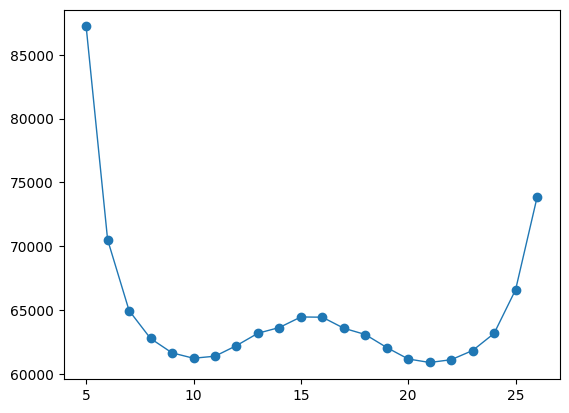

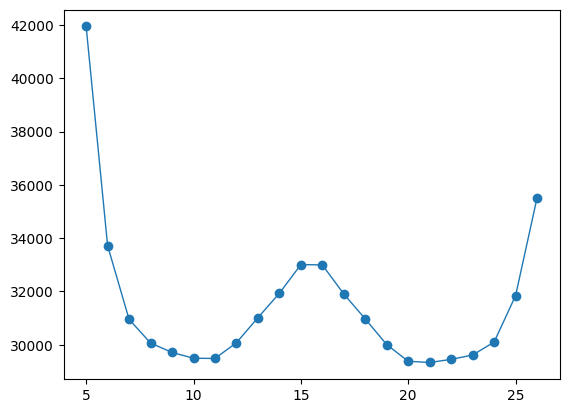

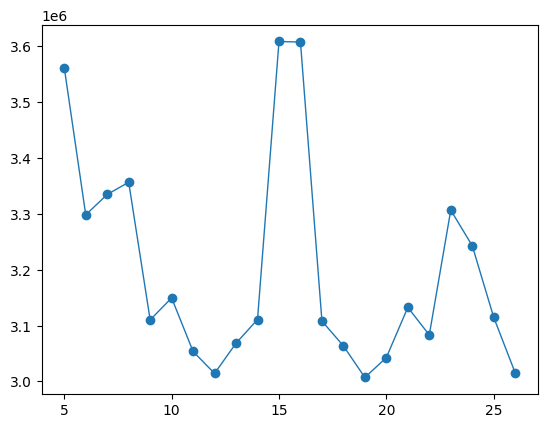

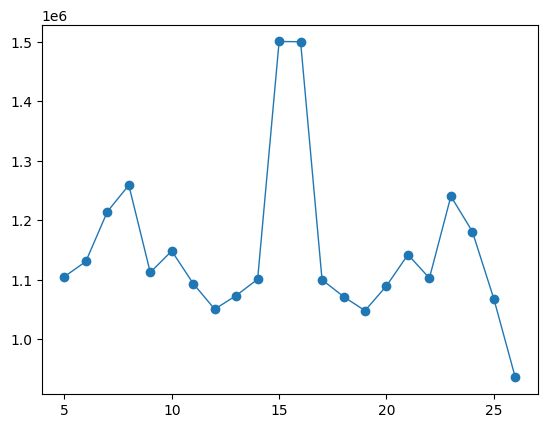

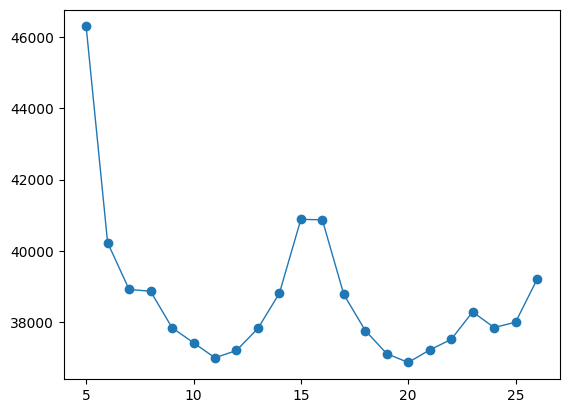

In [82]:
cut = 5

for iop in range(noperators):
    _ = plt.figure()
    #_ = plt.plot(times[cut:-cut],np.mean(mat_ele_squared,axis=0)[iop,cut:-cut],'-o',linewidth=1)
    _ = plt.plot(times[cut:-cut],np.mean(mat_ele,axis=0)[iop,cut:-cut],'-o',linewidth=1)

In [83]:
test_statistic = np.mean

mat_ele_jack = np.empty(shape=(noperators,tvals),dtype=float)
mat_ele_jack_std = np.empty(shape=(noperators,tvals),dtype=float)

for t in range(tvals):
    for iop in range(noperators):

        #data = mat_ele_squared[:,iop,t]
        data = mat_ele[:,iop,t]

        estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

        mat_ele_jack[iop,t] = estimate
        mat_ele_jack_std[iop,t] = stderr

In [62]:
'''
test_statistic = np.mean

mat_ele_jack = np.empty(shape=(noperators,tvals),dtype=float)
mat_ele_jack_std = np.empty(shape=(noperators,tvals),dtype=float)

for t in range(tvals):
    for iop in range(noperators):

        #data = mat_ele_squared[:,iop,t]
        data = mat_ele[:,iop,t]

        estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

        mat_ele_jack[iop,t] = estimate
        mat_ele_jack_std[iop,t] = stderr
        '''

'\ntest_statistic = np.mean\n\nmat_ele_jack = np.empty(shape=(noperators,tvals),dtype=float)\nmat_ele_jack_std = np.empty(shape=(noperators,tvals),dtype=float)\n\nfor t in range(tvals):\n    for iop in range(noperators):\n\n        #data = mat_ele_squared[:,iop,t]\n        data = mat_ele[:,iop,t]\n\n        estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)\n\n        mat_ele_jack[iop,t] = estimate\n        mat_ele_jack_std[iop,t] = stderr\n        '

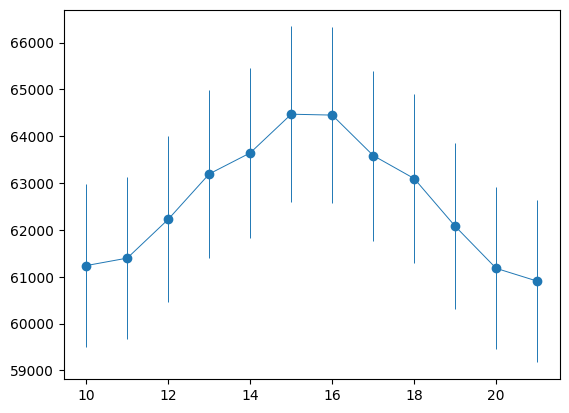

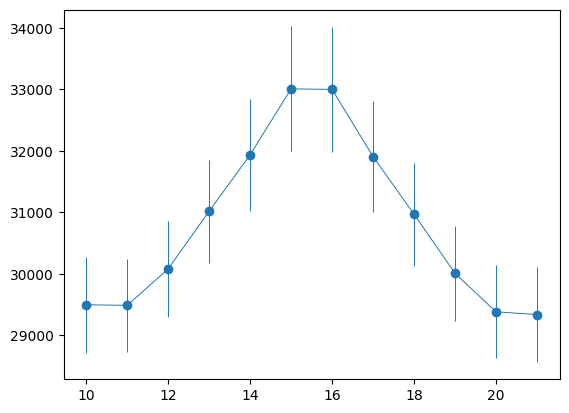

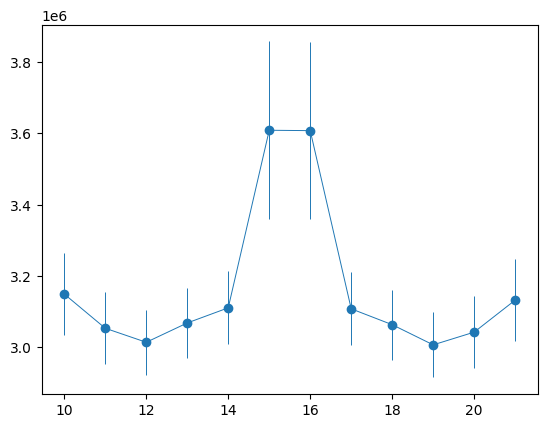

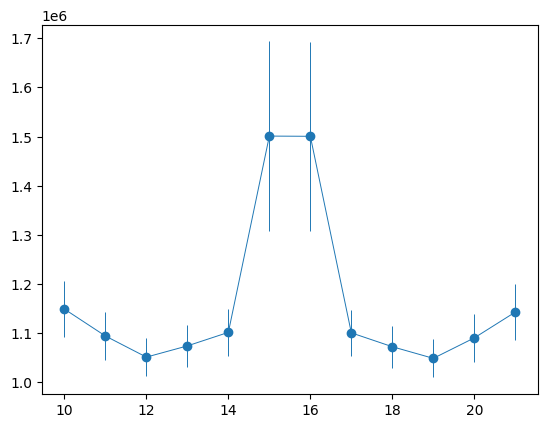

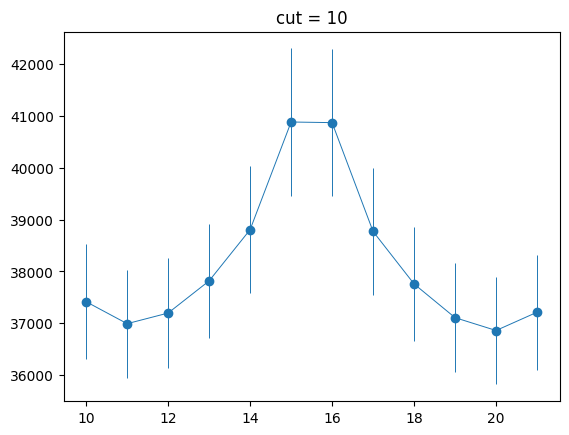

In [84]:
cut = 10

for iop in range(noperators):
    _ = plt.figure()
    _ = plt.errorbar(times[cut:-cut],mat_ele_jack[iop,cut:-cut],yerr=mat_ele_jack_std[iop,cut:-cut],marker='o',linewidth=0.7)

_ = plt.title(f"cut = {cut}")

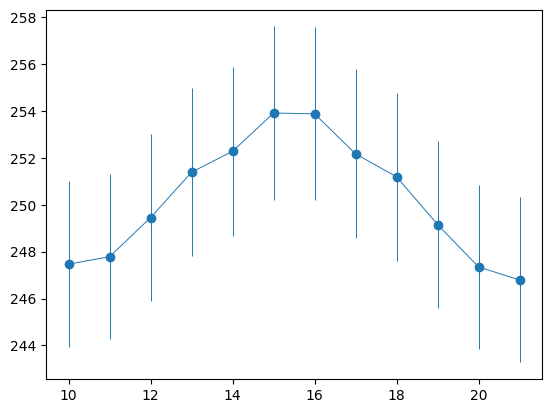

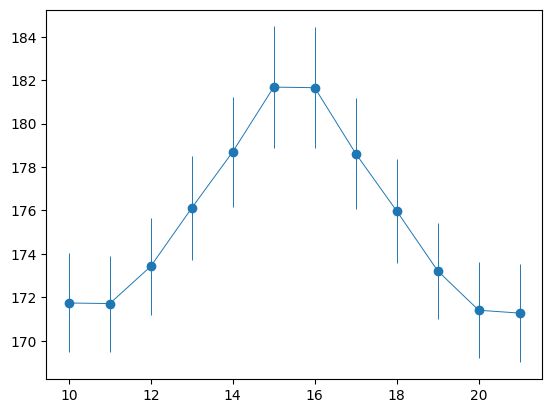

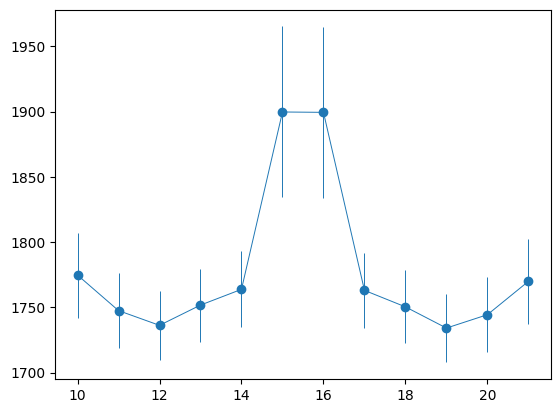

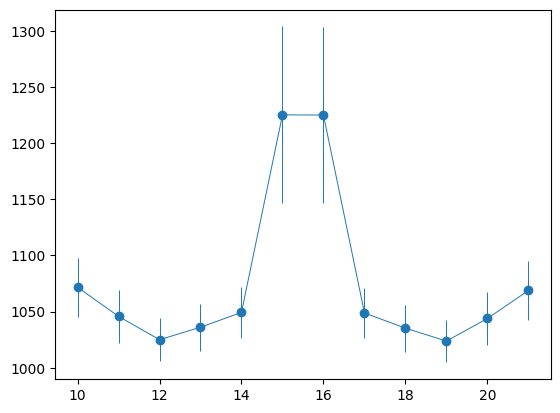

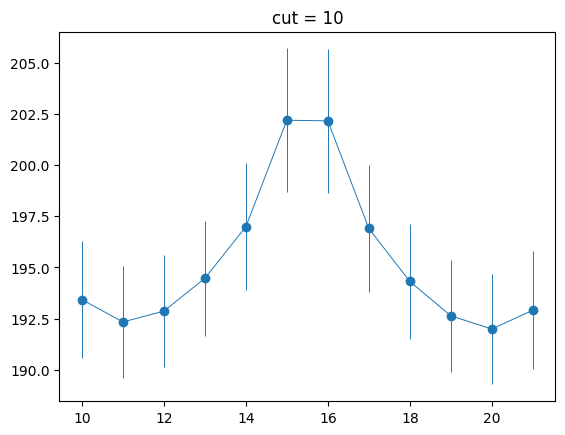

In [85]:
cut = 10

for iop in range(noperators):
    _ = plt.figure()
    _ = plt.errorbar(times[cut:-cut],np.sqrt(mat_ele_jack[iop,cut:-cut]),yerr=1/2 * mat_ele_jack_std[iop,cut:-cut]/np.sqrt(mat_ele_jack[iop,cut:-cut]),marker='o',linewidth=0.7)

_ = plt.title(f"cut = {cut}")

In [86]:
final_mat_ele = [np.sqrt(mat_ele_jack[iop,cut:-cut]).mean() for iop in range(noperators)]
final_mat_ele_std = np.sqrt(np.array([((1/2 * mat_ele_jack_std[iop,cut:-cut]/np.sqrt(mat_ele_jack[iop,cut:-cut]))**2).mean() for iop in range(noperators)]))

print(final_mat_ele)
print(final_mat_ele_std)

[250.23223254714458, 175.46002032855822, 1777.8624088440793, 1074.878897900804, 195.2677640844494]
[ 3.5752239   2.41255166 37.6269959  38.18493299  2.97096367]


# further analysis

## 2 points from oddrun

In [87]:
new2x_navg = all_2point_z.mean(axis=-1)[:,0,:]
new2z_navg = all_2point_x.mean(axis=-1)[:,0,:]

if verbose:
    print("(nconf),tvals")
    np.shape(new2x_navg)
    np.shape(new2z_navg)

(nconf),tvals


(991, 32)

(991, 32)

Text(0.5, 1.0, 'cut = 5')

<Figure size 640x480 with 0 Axes>

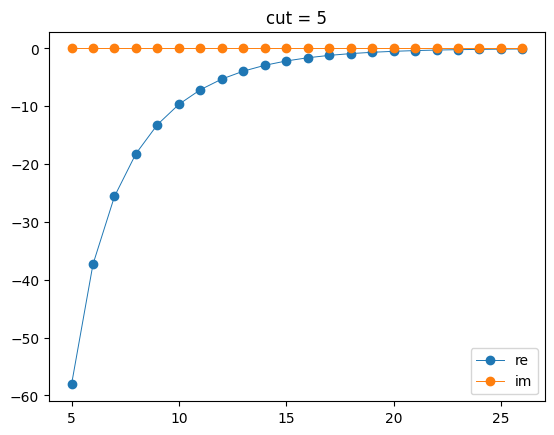

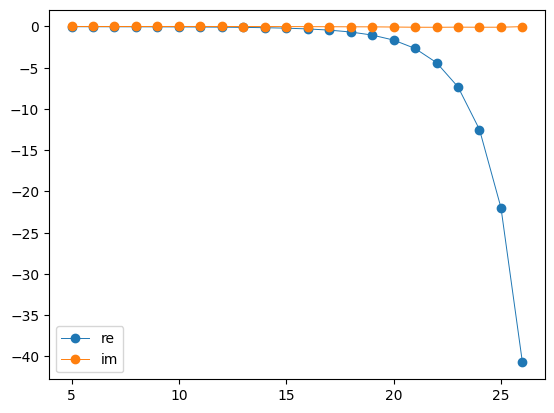

In [88]:
times=np.arange(tvals)
cut=5
plt.title(f"cut = {cut}")
plt.plot(times[cut:-cut],np.mean(new2x_navg,axis=0)[cut:-cut].real,'-o',linewidth=0.7,label='re')
plt.plot(times[cut:-cut],np.mean(new2x_navg,axis=0)[cut:-cut].imag,'-o',linewidth=0.7,label='im')
plt.legend()
plt.figure()
plt.plot(times[cut:-cut],np.mean(new2z_navg,axis=0)[cut:-cut].real,'-o',linewidth=0.7,label='re')
plt.plot(times[cut:-cut],np.mean(new2z_navg,axis=0)[cut:-cut].imag,'-o',linewidth=0.7,label='im')
plt.legend()

In [89]:
test_statistic = np.mean

new2x_navg_jack = np.empty(shape=(tvals),dtype=float)
new2x_navg_jack_std = np.empty(shape=(tvals),dtype=float)
new2z_navg_jack = np.empty(shape=(tvals),dtype=float)
new2z_navg_jack_std = np.empty(shape=(tvals),dtype=float)

for t in range(tvals):

    data = new2x_navg[:,t].real
    
    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    new2x_navg_jack[t] = estimate
    new2x_navg_jack_std[t] = stderr


    data = new2z_navg[:,t].real
    
    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    new2z_navg_jack[t] = estimate
    new2z_navg_jack_std[t] = stderr

Text(0.5, 1.0, 'cut = 5')

<ErrorbarContainer object of 3 artists>

<Figure size 640x480 with 0 Axes>

<ErrorbarContainer object of 3 artists>

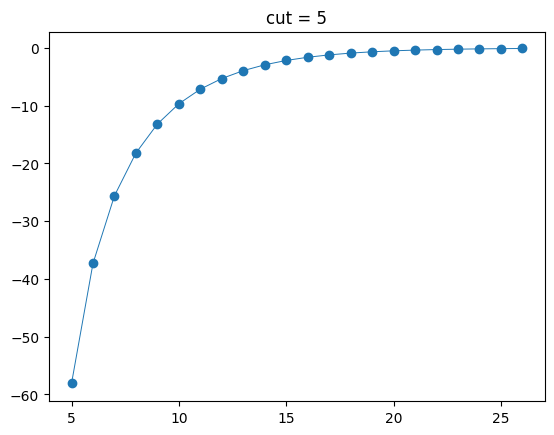

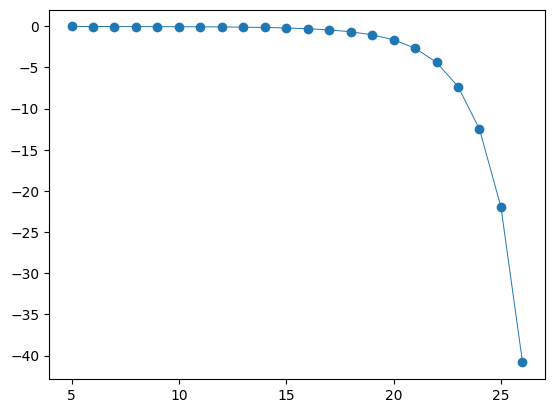

In [90]:
times=np.arange(tvals)
cut=5
plt.title(f"cut = {cut}")
plt.errorbar(times[cut:-cut],new2x_navg_jack[cut:-cut],yerr=new2x_navg_jack_std[cut:-cut],marker='o',linewidth=0.7)
plt.figure()
plt.errorbar(times[cut:-cut],new2z_navg_jack[cut:-cut],yerr=new2z_navg_jack_std[cut:-cut],marker='o',linewidth=0.7)

In [111]:
newnconf = np.shape(new2x_navg_jack)[0]
new_eff_mass_x = np.empty(shape=(newnconf,tvals-1))
new_eff_mass_z = np.empty(shape=(newnconf,tvals-1))

for iconf in range(newnconf):
    new_eff_mass_x[iconf,:] = np.array([np.log(new2x_navg[iconf,i].real/new2x_navg[iconf,i+1].real) for i in range(tvals-1)])
    #new_eff_mass_z[iconf,:] = np.array([np.log(new2z_navg[iconf,i-1].real/new2z_navg[iconf,i].real) for i in range(1,tvals)])
    new_eff_mass_z[iconf,:] = np.array([np.log(new2z_navg[iconf,tvals-i].real/new2z_navg[iconf,tvals-i-1].real) for i in range(1,tvals)])

if verbose:
    print("(nconf,tvals-1)")
    print(np.shape(eff_mass_x))
    print(np.shape(eff_mass_z))

(nconf,tvals-1)
(914, 31)
(914, 31)


/tmp/ipykernel_64357/2178930174.py:6: RuntimeWarning: divide by zero encountered in log
  new_eff_mass_x[iconf,:] = np.array([np.log(new2x_navg[iconf,i].real/new2x_navg[iconf,i+1].real) for i in range(tvals-1)])
/tmp/ipykernel_64357/2178930174.py:6: RuntimeWarning: divide by zero encountered in scalar divide
  new_eff_mass_x[iconf,:] = np.array([np.log(new2x_navg[iconf,i].real/new2x_navg[iconf,i+1].real) for i in range(tvals-1)])
/tmp/ipykernel_64357/2178930174.py:6: RuntimeWarning: invalid value encountered in log
  new_eff_mass_x[iconf,:] = np.array([np.log(new2x_navg[iconf,i].real/new2x_navg[iconf,i+1].real) for i in range(tvals-1)])
/tmp/ipykernel_64357/2178930174.py:8: RuntimeWarning: divide by zero encountered in log
  new_eff_mass_z[iconf,:] = np.array([np.log(new2z_navg[iconf,tvals-i].real/new2z_navg[iconf,tvals-i-1].real) for i in range(1,tvals)])
/tmp/ipykernel_64357/2178930174.py:8: RuntimeWarning: invalid value encountered in log
  new_eff_mass_z[iconf,:] = np.array([np.log

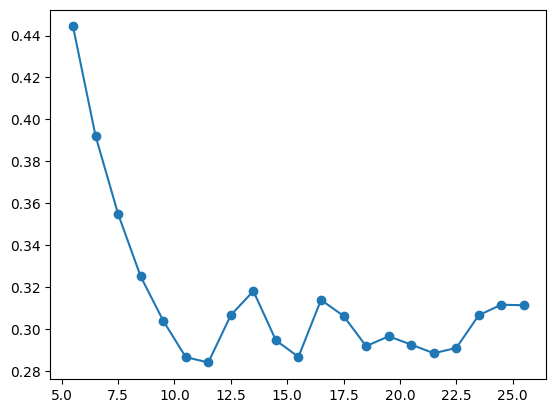

In [115]:
cut = 5
plt.plot(eff_mass_times[cut:-cut],new_eff_mass_x.mean(axis=0)[cut:-cut],'-o')
#plt.plot(eff_mass_times,new_eff_mass_z.mean(axis=0),'-o')

In [93]:
new_eff_mass_x_jack = np.empty(shape=(tvals-1),dtype=float)
new_eff_mass_x_jack_std = np.empty(shape=(tvals-1),dtype=float)

for t in range(tvals-1):

    data = new_eff_mass_x[:,t].real

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    new_eff_mass_x_jack[t] = estimate
    new_eff_mass_x_jack_std[t] = stderr

Text(0.5, 1.0, 'cut=8')

<ErrorbarContainer object of 3 artists>

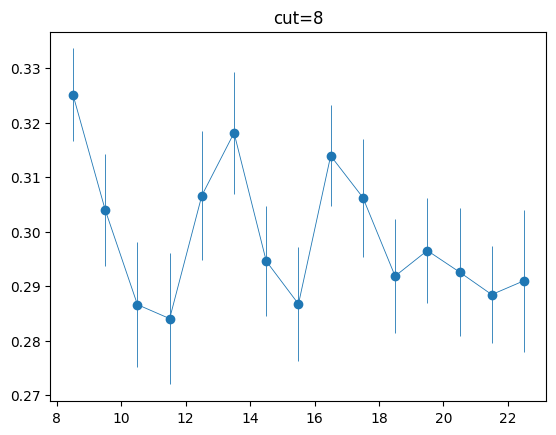

In [94]:
cut=8
plt.title(f"cut={cut}")
plt.errorbar(eff_mass_times[cut:-cut],new_eff_mass_x_jack[cut:-cut],yerr=new_eff_mass_x_jack_std[cut:-cut],marker='o',linewidth=0.6)

In [95]:
np.mean(new_eff_mass_x_jack[cut:-cut])
np.sqrt(np.mean( new_eff_mass_x_jack_std[cut:-cut]**2 ))

0.29909147854651263

0.010702740538962833

# Direct fit of mat element

In [96]:
nconf = np.shape(corr_x_navg)[0]

corr_3p = all_correlators[:nconf,0,0,:,:,:,:] + all_correlators[:nconf,1,0,:,:,:,:]
corr_3p_navg = corr_3p.mean(axis=-1).mean(axis=-1)


if verbose:
    print("(nconf',tvals)")
    print(np.shape(corr_x_navg))
    print(np.shape(corr_z_navg))
    print("(nconf',noperators,tvals)")
    print(np.shape(corr_3p_navg))

(nconf',tvals)
(914, 32)
(914, 32)
(nconf',noperators,tvals)
(914, 5, 32)


In [97]:
#jackknife
test_statistic = np.mean

corr_x_navg_jack = np.empty(shape=(tvals),dtype=float)
corr_x_navg_jack_std = np.empty(shape=(tvals),dtype=float)
corr_z_navg_jack = np.empty(shape=(tvals),dtype=float)
corr_z_navg_jack_std = np.empty(shape=(tvals),dtype=float)
corr_3p_navg_jack = np.empty(shape=(noperators,tvals),dtype=float)
corr_3p_navg_jack_std = np.empty(shape=(noperators,tvals),dtype=float)


for t in range(tvals):

    data = corr_x_navg[:,t].real

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corr_x_navg_jack[t] = estimate
    corr_x_navg_jack_std[t] = stderr

    if np.abs(bias/estimate)>10**-10:
        print(f"x / {t} / {bias}")



    data = corr_z_navg[:,t].real

    estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

    corr_z_navg_jack[t] = estimate
    corr_z_navg_jack_std[t] = stderr

    if np.abs(bias/estimate)>10**-10:
        print(f"z / {t} / {bias}")

    for iop in range(noperators):

        data = corr_3p_navg[:,iop,t].imag

        estimate, bias, stderr, conf_interval = jackknife_stats(data, test_statistic, 0.95)

        corr_3p_navg_jack[iop,t] = estimate
        corr_3p_navg_jack_std[iop,t] = stderr

        if np.abs(bias/estimate)>10**-10:
            print(f"3p / {iop} / {t} / {bias}")

/tmp/ipykernel_64357/3740280375.py:21: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(bias/estimate)>10**-10:
/tmp/ipykernel_64357/3740280375.py:33: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(bias/estimate)>10**-10:
/tmp/ipykernel_64357/3740280375.py:45: RuntimeWarning: invalid value encountered in scalar divide
  if np.abs(bias/estimate)>10**-10:


In [98]:
element1 = np.empty(shape=(noperators,tvals),dtype=float)
element2 = np.empty(shape=(noperators,tvals),dtype=float)
fit_data = np.empty(shape=(noperators,tvals),dtype=float)



for iop in range(noperators):

    element1[iop,:] = corr_3p_navg_jack[iop,:]/corr_z_navg_jack[:]

    element2[iop,:] = corr_3p_navg_jack[iop,::-1]/corr_x_navg_jack[::-1]

    #result[iop,:] = element1[iop,:] * np.conjugate(element2[iop,:])
    fit_data[iop,:] = element1[iop,:] * (-element2[iop,:]) #since the three point is fully imaginary conjugation equals a minus overall

/tmp/ipykernel_64357/1212303952.py:9: RuntimeWarning: invalid value encountered in divide
  element1[iop,:] = corr_3p_navg_jack[iop,:]/corr_z_navg_jack[:]
/tmp/ipykernel_64357/1212303952.py:11: RuntimeWarning: invalid value encountered in divide
  element2[iop,:] = corr_3p_navg_jack[iop,::-1]/corr_x_navg_jack[::-1]


In [99]:
def final_fit_func(t,amp,M,deltaM):
    return amp /(np.cosh(t*M)-np.cosh(t*deltaM))

Result x:
amp:  163.74660602816533 +- 390335883.75707275
M:    1.4680629644058067 +- 228.0889557341169

dM:   1.467871537540305 +- 228.23062111399477

acutal amp = 1421.5886498207717
mps  = 1.467967250973056
mpst = 9.571343275083244e-05


/tmp/ipykernel_64357/2372269385.py:2: RuntimeWarning: overflow encountered in cosh
  return amp /(np.cosh(t*M)-np.cosh(t*deltaM))
/tmp/ipykernel_64357/2372269385.py:2: RuntimeWarning: invalid value encountered in subtract
  return amp /(np.cosh(t*M)-np.cosh(t*deltaM))


<Figure size 640x480 with 0 Axes>

Result x:
amp:  64.60737751651297 +- 531954890.0952605
M:    1.4677149036815877 +- 615.6903345314612

dM:   1.4675653149578969 +- 615.9718892812989

acutal amp = 560.7026288042589
mps  = 1.4676401093197424
mpst = 7.479436184543165e-05


<Figure size 640x480 with 0 Axes>

Result x:
amp:  7426.652380830308 +- 1698548638.578451
M:    -1.3198057739809845 +- 51.222008004888615

dM:   1.3193574611970844 +- 51.307147123567894

acutal amp = 3968.6127857087686
mps  = -0.00022415639195005888
mpst = -1.3195816175890345


<Figure size 640x480 with 0 Axes>

Result x:
amp:  1373205.6485309748 +- 30314.121978909843
M:    -1.38366615657801 +- 0.0034799665009095054

dM:   0.0009992584129027583 +- 83.12739300474155

acutal amp = 688409.7303459797
mps  = -0.6913334490825536
mpst = -0.6923327074954564


<Figure size 640x480 with 0 Axes>

Result x:
amp:  25.93650199408601 +- 18669742.678606424
M:    1.3860232234680894 +- 30.61143027825022

dM:   1.3859382015215715 +- 30.589492539966024

acutal amp = 207.43576468097865
mps  = 1.3859807124948305
mpst = 4.251097325891351e-05


<Figure size 640x480 with 0 Axes>

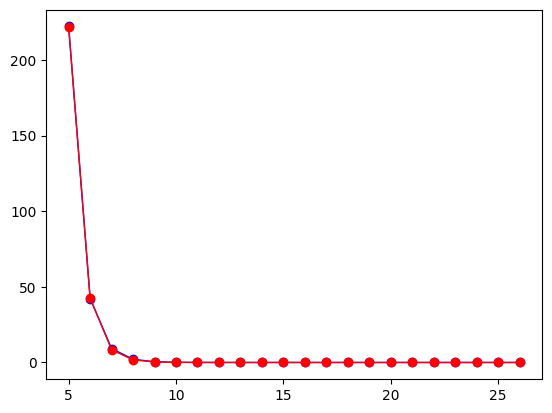

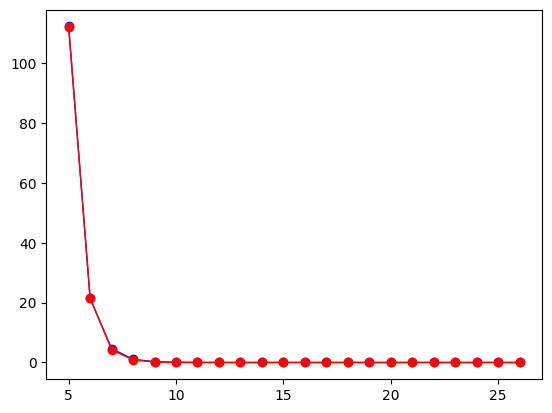

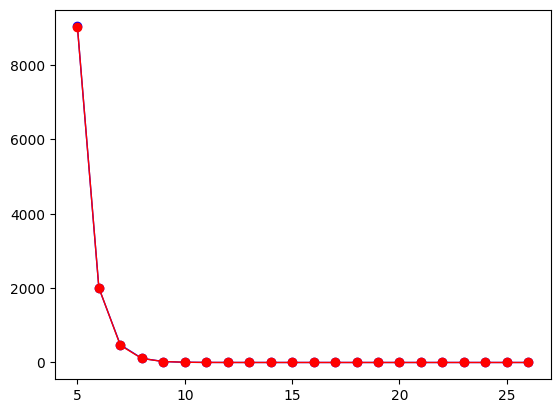

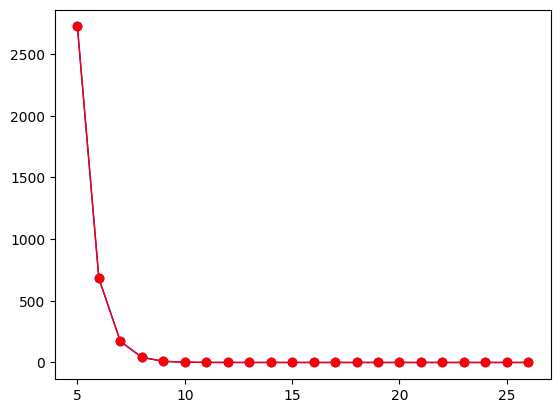

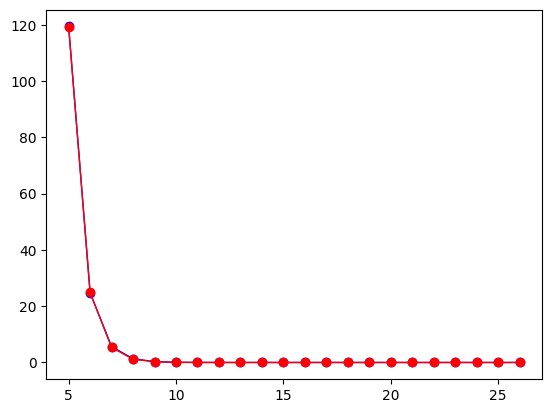

In [100]:
for iop in range(noperators):

    guess_amp = final_mat_ele[iop]
    guess_M = mps+mpst
    guess_deltaM = mps-mpst

    cut = 5

    fit_times = times[cut:-cut]

    fit_data_iop = fit_data[iop,cut:-cut]

    guess = [guess_amp,guess_M,guess_deltaM]

    popt,pcov = curve_fit(final_fit_func, fit_times, fit_data_iop, p0=guess)
    perr = np.sqrt(np.diag(pcov))
    fit_result = final_fit_func(fit_times,*popt)

    print("Result x:")
    print(f"amp:  {popt[0]} +- {perr[0]}")
    print(f"M:    {popt[1]} +- {perr[1]}\n")
    print(f"dM:   {popt[2]} +- {perr[2]}\n")

    print(f"acutal amp = {2*popt[0]*np.exp(popt[1])}")
    print(f"mps  = {0.5*(popt[1]+popt[2])}")
    print(f"mpst = {0.5*(popt[1]-popt[2])}")

    plt.figure()
    plt.plot(fit_times,fit_data_iop,'-o',label='data',color='blue',linewidth=1)
    plt.plot(fit_times,fit_result,'-o',label='fit',color='red',linewidth=1)
    #plt.yscale('log')
    #print(f"chi2: {chi2(fit_result,fit_data_iop,fp_std[cut:-cut])}")